In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import collections as clt
from community import best_partition,modularity
import itertools

In [2]:
df = pd.read_csv('reviews_full_v2-2.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.read_gpickle('network_users.p')

In [5]:
def calc_modular(Graph, n_iter):
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    for i in range(n_iter):# for n_iter number of iterations
        partition = best_partition(Graph, randomize = True, weight = 'weight')
        total += modularity(partition, Graph)
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        ave_density = 0
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if (u,v) not in prob:
                    prob[(u,v)] = 0
                prob[(u,v)] += 1/n_iter
            SG = G.subgraph(mp[part])
            n = len(mp[part])
            if n > 1:
                ave_density += len(SG.edges())/(n*(n-1)/2)
            else:
                ave_density += 1
        ave_density /= len(mp)
    return prob, total/n_iter, ave_density ,np.mean([min(x,1-x) for x in prob.values()])#closeness to 0 or 1

In [6]:
'''import time
a = time.time()
prob,ave_mod,ave_prob = calc_modular(G,20)
print(time.time()-a)'''

'import time\na = time.time()\nprob,ave_mod,ave_prob = calc_modular(G,20)\nprint(time.time()-a)'

In [7]:
def modular_range(sim_x, Graph):
    #runs in linear time, but needs to be initialised from mallest to largest after reverse
    #takes in a range of values and adds edges individually from greatest to smallest similarity
    #used for range query
    #range query reduces run time as graph is only constructed once
    #returns list of modularity scores, density, etc.
    sim_x.reverse()
    pos = 0
    GC_split = nx.Graph()
    GC_split.add_nodes_from(Graph.nodes())
    edges = []
    for u,v in Graph.edges():
        edges.append((Graph[u][v]['similarity'],u,v))
    edges.sort(reverse = True)
    ret = []
    for sim in sim_x:
        for i in range(pos,len(edges)):
            edgesim, u, v = edges[i]
            if edgesim >= sim:
                GC_split.add_edge(u,v)
            else:
                pos = i
                break
        ret.append(calc_modular(GC_split,10)[1:])
    ret.reverse()
    sim_x.reverse()
    return ret

def filter_sim(Graph, sim,params = True):
    #this function generates a graph which is a collection of subgraphs from the original graph
    #after removing all edges with similarity < sim, where sim is to be determined
    #to generate full graph, used for point query
    GC_split = nx.Graph()
    GC_split.add_nodes_from(Graph.nodes())
    for u,v in Graph.edges():
        if Graph[u][v]['similarity'] >= sim:
            GC_split.add_edge(u,v)
            if params == True:
                GC_split[u][v]['weight'] = Graph[u][v]['weight']
                GC_split[u][v]['similarity'] = Graph[u][v]['similarity']
                GC_split[u][v]['releases'] = Graph[u][v]['releases']
                GC_split[u][v]['year'] = Graph[u][v]['year']
    return GC_split

In [8]:
sim_x = [x/100 for x in range(0,5)]
ret = modular_range(sim_x,G)
mod_y = [x[0] for x in ret]
density_y = [x[1] for x in ret]
ave_y = [x[2] for x in ret]#average difference from 0 or 1

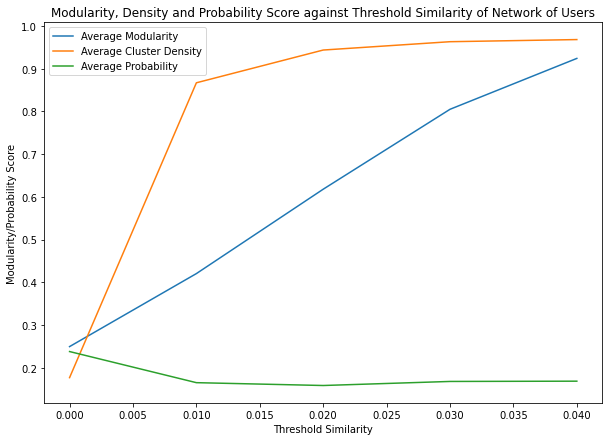

In [9]:
plt.title('Modularity, Density and Probability Score against Threshold Similarity of Network of Users')
plt.ylabel('Modularity/Probability Score')
plt.xlabel('Threshold Similarity')
plt.plot(sim_x,mod_y, label = 'Average Modularity')
plt.plot(sim_x,density_y, label = 'Average Cluster Density')
plt.plot(sim_x,ave_y, label = 'Average Probability')
plt.legend()
plt.savefig('Modularity and Probability Score against Threshold Similarity of Network of Users.png')
plt.show()

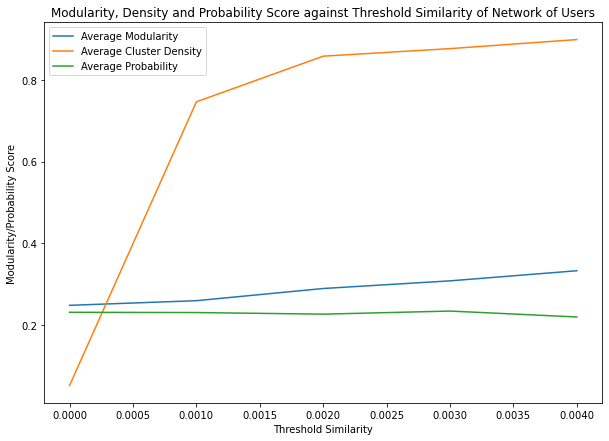

In [19]:
sim_x = [x/1000 for x in range(0,5)]
ret = modular_range(sim_x,G)
mod_y = [x[0] for x in ret]
density_y = [x[1] for x in ret]
ave_y = [x[2] for x in ret]#average difference from 0 or 1
plt.title('Modularity, Density and Probability Score against Threshold Similarity of Network of Users')
plt.ylabel('Modularity/Probability Score')
plt.xlabel('Threshold Similarity')
plt.plot(sim_x,mod_y, label = 'Average Modularity')
plt.plot(sim_x,density_y, label = 'Average Cluster Density')
plt.plot(sim_x,ave_y, label = 'Average Probability')
plt.legend()
plt.savefig('Modularity and Probability Score against Threshold Similarity of Network of Users (0-0.007).png')
plt.show()

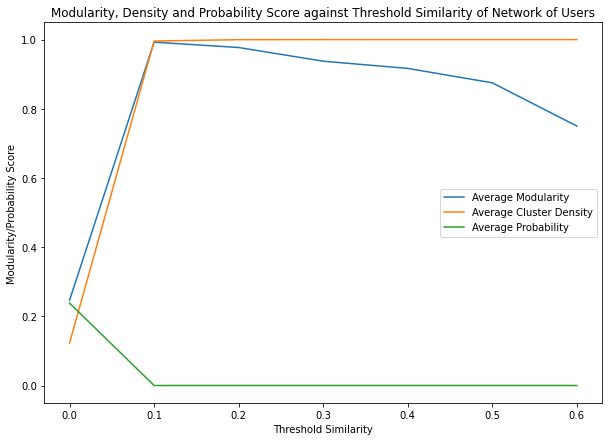

In [18]:
sim_x = [x/10 for x in range(0,7)]
ret = modular_range(sim_x,G)
mod_y = [x[0] for x in ret]
density_y = [x[1] for x in ret]
ave_y = [x[2] for x in ret]#average difference from 0 or 1
plt.title('Modularity, Density and Probability Score against Threshold Similarity of Network of Users')
plt.ylabel('Modularity/Probability Score')
plt.xlabel('Threshold Similarity')
plt.plot(sim_x,mod_y, label = 'Average Modularity')
plt.plot(sim_x,density_y, label = 'Average Cluster Density')
plt.plot(sim_x,ave_y, label = 'Average Probability')
plt.legend()
plt.savefig('Modularity and Probability Score against Threshold Similarity of Network of Users (all).png')
plt.show()

Based on the above graph, it is decided that a threshold similarity of 0.002 is used.

In [12]:
genres = {}
temp = set()
for i,user in enumerate(df['User']):
    if user not in genres:
         genres[user] = set()
    if df['Genre'][i] != df['Genre'][i]:
        #genresNew.append('')
        continue
    #tmp = [x.replace("'",'').replace('"','').lstrip().rstrip() for x in df['Genre'][i][1:-1].split(',')]
    #genresNew.append(str(tmp)[1:-1].replace(', ','|').replace("'",''))
    genres[user].update(df['Genre'][i].lower().split('|'))
    temp.update(df['Genre'][i].lower().split('|'))

In [13]:
len(temp)

297

In [14]:
#H = filter_sim(G,0.001, False)
H = G
partition = best_partition(H, randomize = True)
parts = {}
mp = {}
for user in partition:
    if partition[user] not in parts:
        parts[partition[user]] = set()
        mp[partition[user]] = list()
    mp[partition[user]].append(user)
    parts[partition[user]].update(genres[user])

In [15]:
for item in mp:
    #if len(mp[item]) < 3:
        #continue
    print(item, len(mp[item]), len(parts[item]))

0 725 239
1 462 189
2 1101 230
3 699 243
4 369 175
5 71 101
6 149 187


In [16]:
print(parts[4])

{'avant-garde black metal', 'drone', 'technical metalcore', 'punk', 'symphonic death metal', 'avantgarde black metal', 'post-punk', 'rock', 'blues rock', 'instrumental post-metal', 'fusion', 'symphonic gothic metal', 'krautrock', 'viking black metal', 'atmospheric sludge metal', 'progressive grindcore', 'ambient', 'sludge metal', 'neoclassical', 'bay area thrash metal', 'crust punk', 'melodic metalcore', 'industrial progressive metal', 'electronic avantgarde', 'technical thrash metal', 'dance', 'acoustic folk metal', 'post-metal', 'deathgrind', 'jazz rock', 'blackened thrash metal', 'experimental black metal', 'gothic black metal', 'black metal', 'progressive sludge metal', 'atmospheric rock', 'noise', 'glam rock', 'metalcore', 'progressive rock', 'gothic doom metal', 'glam metal', 'psychedelic stoner metal', 'psychedelic rock', 'atmospheric gothic metal', 'shoegaze', 'post-black metal', 'melodic thrash metal', 'pagan black metal', 'neoclassical power metal', 'extreme progressive metal

In [17]:
temp

{'a cappella',
 'accustic',
 'acoustic',
 'acoustic folk',
 'acoustic folk metal',
 'acoustic rock',
 'adult oriented rock',
 'alternative metal',
 'alternative rock',
 'alternative thrash metal',
 'ambient',
 'ambient black metal',
 'ambient darkwave',
 'ambient doom metal',
 'ambient drone',
 'ambient folk',
 'ambient noise',
 'atmospheric black metal',
 'atmospheric death metal',
 'atmospheric doom metal',
 'atmospheric gothic metal',
 'atmospheric progressive metal',
 'atmospheric rock',
 'atmospheric sludge metal',
 'avant-garde black metal',
 'avantgarde black metal',
 'avantgarde death metal',
 'avantgarde doom metal',
 'avantgarde industrial metal',
 'avantgarde metal',
 'bay area thrash metal',
 'black doom metal',
 'black metal',
 'black n roll',
 'blackened death metal',
 'blackened doom metal',
 'blackened folk metal',
 'blackened gothic metal',
 'blackened grindcore',
 'blackened hardcore',
 'blackened heavy metal',
 'blackened industrial metal',
 'blackened progressive me

In [20]:
'''import pandas as pd
import numpy as np
df = pd.read_csv('reviews_full_v2-2.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
tmp = []
for item in df['Genre']:
    if item != item:
        tmp.append(np.nan)
    else:
        tmp.append(item.lower())
df['Genre'] = tmp
df.to_csv('reviews_full_v3.csv', index = False)'''

In [13]:
list(df['Genre']).count(np.nan)/len(df)

0.2903867970974164

In [19]:
genres = set()
for item in df['Genre']:
    if item != item:
        continue
    genres.update(item.split('|'))

f = open('genres.txt','w')
    
for item in genres:
    f.write(item+'\n')
f.close()
len(genres)

297